# 実践コンピュータビジョン
# 3章 画像間の写像

## 3.2 画像の変形
テキストp.59  

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline

### (1) scipy.ndimage  
scipyパッケージには多くのモジュールが含まれている。ここでは画像処理を行うndimageを使う。<br>
scipy.ndimage内のアフィン変換モジュール affine_transform()を使って、画像を変換する簡単な例。

In [2]:
from scipy import ndimage

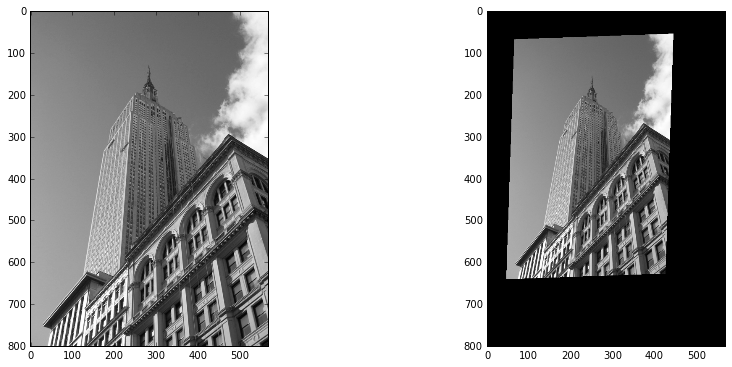

In [3]:
# ビルの写真を歪ませる
# fig 3-1, p.60
im = np.array(Image.open('data/empire.jpg').convert('L'))
H = np.array([[1.4, 0.05, -100], [0.05, 1.5, -100], [0,0,1]])
im2 = ndimage.affine_transform(im, H[:2, :2], (H[0,2], H[1,2]))

plt.figure(figsize=(15,6))
plt.gray()
plt.subplot(1,2,1)
plt.imshow(im)
plt.subplot(1,2,2)
plt.imshow(im2)
plt.show()

### (2) イメージの貼り付け  
warp.py内の関数を使い、ネコの画像を広告看板に貼付ける例。

In [4]:
import warp

/Users/takeshi/anaconda/lib/python3.4/site-packages/matplotlib/cbook.py:137: MatplotlibDeprecationWarning: The matplotlib.delaunay module was deprecated in version 1.4. Use matplotlib.tri.Triangulation instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


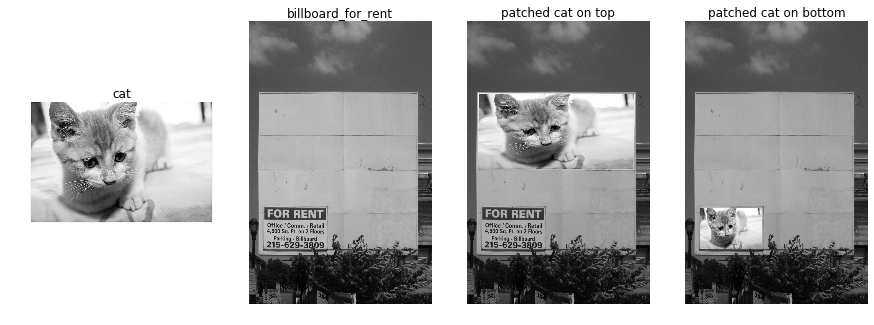

In [5]:
# fig 3-2, p.61
# im1からim2へアフィン変換で変形する例
im1 = np.array(Image.open('data/cat.jpg').convert('L'))
im2 = np.array(Image.open('data/billboard_for_rent.jpg').convert('L'))

# 点を設定する
tp1 = np.array([[264, 538, 540, 264], [40, 36, 605, 605], [1,1,1,1]])
# イメージを貼付ける
im3 = warp.image_in_image(im1, im2, tp1)

# 点を設定する
tp2 = np.array([[675,826,826,677], [55,52,281,277], [1,1,1,1]])
# イメージを貼付ける
im4 = warp.image_in_image(im1, im2, tp2)

imlist = [im1, im2, im3, im4]
tlist = ['cat', 'billboard_for_rent', 'patched cat on top', 'patched cat on bottom']

plt.figure(figsize=(15,15))
plt.gray()
for i, im, t in zip(range(len(imlist)),imlist, tlist):
    plt.subplot(1,4,i+1)
    plt.imshow(im)
    plt.axis('off')
    plt.title(t)

### (3) イメージの貼り付け2
貼り付け先の形状に合わせて、イメージの形状を変換する。

fp: 貼付ける画像の四隅の座標<br>
tp: 貼り付け先の画像の四隅の座標<br>
n個の点群は 3xn の同次座標の行列で定義する<br>

numpy.array([[x0, x1, x2, x3], [y0, y1, y2, y3], [1, 1, 1, 1]])

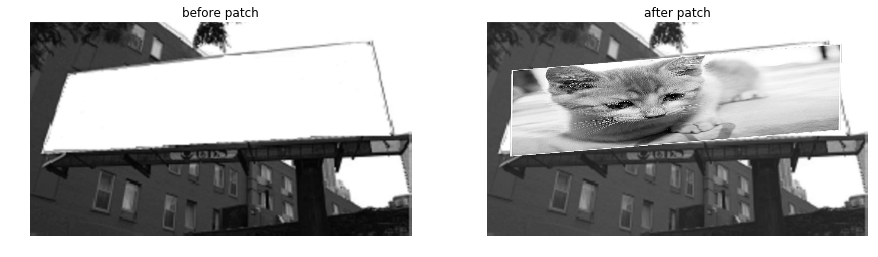

In [6]:
# fig 3-3, p.62

# im1からim2へアフィン変換で変形する例
im1 = np.array(Image.open('data/cat.jpg').convert('L'))
im2 = np.array(Image.open('data/blank_billboard.jpg').convert('L'))

# 点を設定する
tp = np.array([[143,353,302,50],[100,30,980,922],[1,1,1,1]])

im3 = warp.image_in_image(im1,im2,tp)

imlist = [im2, im3]
tlist = ['before patch', 'after patch']

plt.figure(figsize=(15,15))
plt.gray()
for i, im, t in zip(range(len(imlist)),imlist, tlist):
    plt.subplot(1,2,i+1)
    plt.imshow(im)
    plt.axis('off')
    plt.title(t)

### (4) イメージの貼り付け3
ゆがんだ形状に対して、貼り付けイメージの形状を合わせる。

In [7]:
import homography

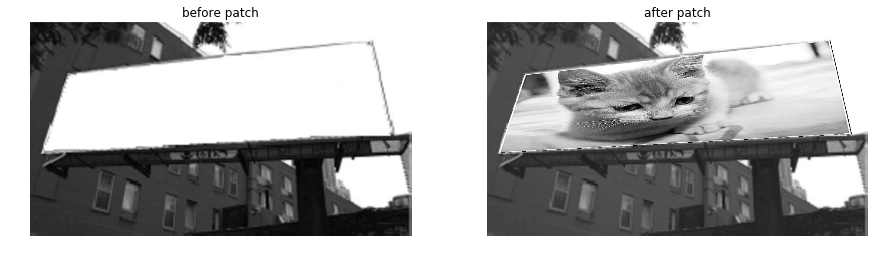

In [9]:
# im1の四隅の座標を設定する
m,n = im1.shape[:2] 
fp = np.array([[0,m,m,0],[0,0,n,n],[1,1,1,1]]) 

# 第1の三角形
tp2 = tp[:,:3] 
fp2 = fp[:,:3] 

# H を計算する
H = homography.Haffine_from_points(tp2,fp2)
im1_t = ndimage.affine_transform(im1, H[:2, :2],
                                (H[0,2], H[1,2]), im2.shape[:2])

# 三角形の透明度マップ
alpha = warp.alpha_for_triangle(tp2, im2.shape[0], im2.shape[1])
im3 = (1-alpha)*im2 + alpha*im1_t

# 第２の三角形
# 第1の三角形と対になるようp[:,[0,2,3]] として3点を選ぶ
tp2 = tp[:, [0,2,3]]
fp2 = fp[:, [0,2,3]]

# H を計算する
H = homography.Haffine_from_points(tp2,fp2)
im1_t = ndimage.affine_transform(im1, H[:2, :2],
                                (H[0,2], H[1,2]), im2.shape[:2])

# 三角形の透明度マップ
alpha = warp.alpha_for_triangle(tp2, im2.shape[0], im2.shape[1])
im4 = (1-alpha)*im3 + alpha*im1_t

imlist = [im2, im4]
tlist = ['before patch', 'after patch']

plt.figure(figsize=(15,15))
plt.gray()
for i, im, t in zip(range(len(imlist)),imlist, tlist):
    plt.subplot(1,2,i+1)
    plt.imshow(im)
    plt.axis('off')
    plt.title(t)


### 3.2.2 分割アフィンワーピング
テキストp.63  
ランダムに作成した点群データにドロネー三角形分割法を適用する例  

In [10]:
from numpy import random
import matplotlib.delaunay as md

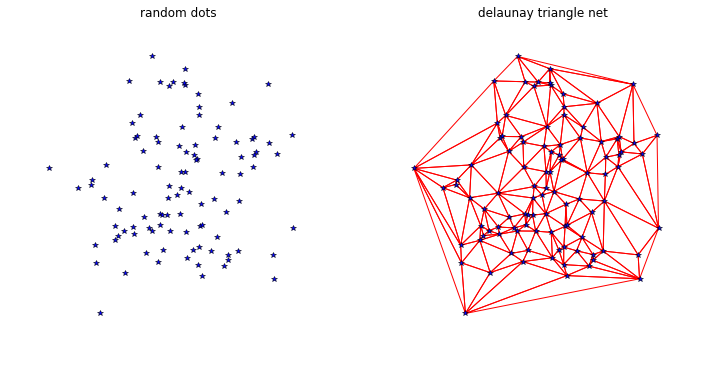

In [11]:
# ランダムな点群の生成
random.seed(0)
x,y = np.array(random.standard_normal((2,100)))
centers, edges, triangle, neighbors = md.delaunay(x,y)

plt.figure(figsize=(12,6))

# ランダムな点群をプロットする
plt.subplot(1,2,1)
plt.plot(x,y,'*')
plt.axis('off')
plt.title('random dots')

# 点群をドロネー三角形でつなぐ
plt.subplot(1,2,2)
for t in triangle:
    t_ext = [t[0], t[1], t[2], t[0]]     # 第１の点を最後に追加する
    plt.plot(x[t_ext], y[t_ext], 'r')
plt.plot(x,y, '*')
plt.axis('off')
plt.title('delaunay triangle net')
plt.show()

### 分割アフィンワーピングの例
テキスト p.65、fig 3-5<br>
建物の壁に写真を貼付ける

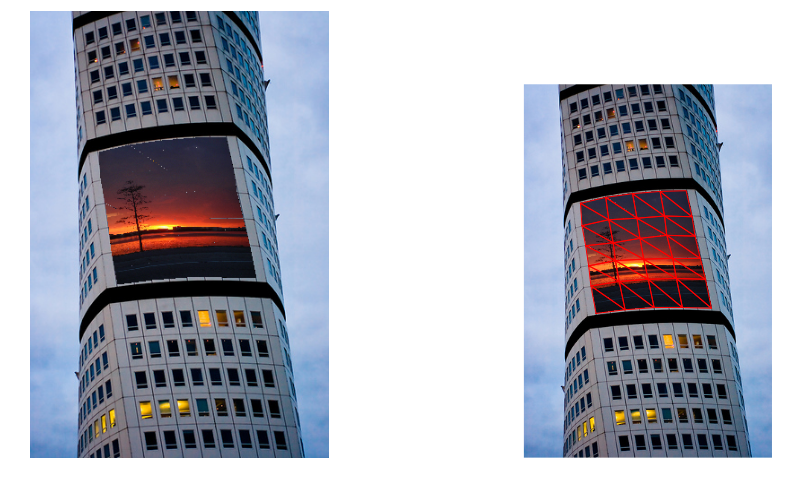

In [15]:
# 変形する画像を開く
fromim = np.array(Image.open('data/sunset_tree.jpg'))
x,y = np.meshgrid(range(5), range(6))
x = (fromim.shape[1]/4) * x.flatten()
y = (fromim.shape[0]/5) * y.flatten()

# 三角形分割する
tri = warp.triangulate_points(x,y)

# 対象の画像と点を開く
im = np.array(Image.open('data/turningtorso1.jpg'))
tp = np.loadtxt('data/turningtorso1_points.txt') # 対応点

# 点を同次座標に変換する
fp = np.vstack((y,x,np.ones((1,len(x)))))
tp = np.vstack((tp[:,1], tp[:,0], np.ones((1,len(tp)))))

# 三角形を変形する
im = warp.pw_affine(fromim, im, fp, tp, tri)

# 描画する
plt.figure(figsize=(15,8))
plt.subplot(1,2,1)
plt.imshow(im)
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(im)
warp.plot_mesh(tp[1], tp[0], tri)
plt.axis('off')
plt.show()